Dans ce notebook, vous apprendrez à classer des images de chats et de chiens en utilisant un transfert learning à partir d'un réseau pré-entraîné sur le jeu de données [ImageNet](https://www.image-net.org/update-mar-11-2021.php).

# Importation des données

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Chargement des données

Téléchargement des données

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68606236/68606236 [==============================] - 0s 0us/step


Sauvegarde des PATH

In [3]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# Fixer les hyperparamètres

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Initialiser les générateurs

Pour le jeu d'entraînement.

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   zoom_range=0.3, 
                                   vertical_flip=True)

train_gen = train_datagen.flow_from_directory(
directory=train_dir, 
target_size=IMG_SIZE, 
batch_size=BATCH_SIZE, 
class_mode='binary', 
shuffle=True)

Found 2000 images belonging to 2 classes.


Pour le jeu de validation.

In [6]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_gen = validation_datagen.flow_from_directory(
directory=validation_dir, 
target_size=IMG_SIZE, 
batch_size=BATCH_SIZE, 
class_mode='binary', 
shuffle=True)

Found 1000 images belonging to 2 classes.


#  Charger un modèle pré-entraîné

In [7]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


Regarder la dimension de ce que le modèle nous retourne à partir de nos images en (160, 160, 3).

In [8]:
feature_batch = base_model.predict(train_gen, steps=1)
print(feature_batch.shape)

1/1 [==============================] - 9s 9s/step
(32, 5, 5, 1280)


Fixer le modèle de base pour que les poids ne soient pas mis-à-jour.

In [9]:
base_model.trainable = False

Viualiser l'architecture du modèle pré-entraîné.

In [10]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Moyenner la dernière couche de convolution en un vecteur grâce à la fonction `GlobalAveragePooling2D`.

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Ajoute une couche `Dense` au modèle.

In [12]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Initialiser le nouveau modèle en prenant en compte les deux couches précédentes.

In [13]:
# layers initialization
inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs =tf.keras.layers.Dense(1, activation="sigmoid")(x)

# model initialization
model = tf.keras.Model(inputs, outputs)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable

# Compiler le modèle

In [15]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

Visualiser le modèle

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable

Regarder le nombre de couches entrainables.

In [17]:
len(model.trainable_variables)

2

# Entraînement du modèle

In [18]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

NameError: ignored

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [20]:
history = model.fit(train_gen,
                    epochs=initial_epochs,
                    validation_data=validation_gen)

Epoch 1/10
63/63 [==============================] - 23s 319ms/step - loss: 0.7175 - accuracy: 0.6080 - val_loss: 0.5237 - val_accuracy: 0.7500
Epoch 2/10
63/63 [==============================] - 20s 312ms/step - loss: 0.5875 - accuracy: 0.7025 - val_loss: 0.4112 - val_accuracy: 0.8450
Epoch 3/10
63/63 [==============================] - 19s 298ms/step - loss: 0.4926 - accuracy: 0.7690 - val_loss: 0.3344 - val_accuracy: 0.8920
Epoch 4/10
63/63 [==============================] - 19s 296ms/step - loss: 0.4467 - accuracy: 0.7925 - val_loss: 0.2896 - val_accuracy: 0.9120
Epoch 5/10
63/63 [==============================] - 18s 289ms/step - loss: 0.4145 - accuracy: 0.8130 - val_loss: 0.2554 - val_accuracy: 0.9320
Epoch 6/10
63/63 [==============================] - 18s 289ms/step - loss: 0.3878 - accuracy: 0.8255 - val_loss: 0.2310 - val_accuracy: 0.9420
Epoch 7/10
63/63 [==============================] - 18s 290ms/step - loss: 0.3789 - accuracy: 0.8325 - val_loss: 0.2100 - val_accuracy: 0.9440

# Les courbes d'apprentissage

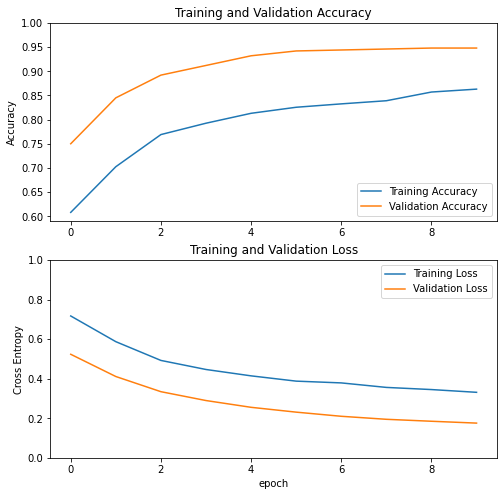

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning

In [22]:
base_model.trainable = True

In [23]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


Compiler le nouveau modèle

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

Visualiser le nouveau modèle

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,862,721
Non-train

Regarder combien de couches sont entrainables.

In [26]:
len(model.trainable_variables)

56

Continuer l'entraînement du modèle avec toutes les couches entrainables.

In [27]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_gen,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_gen)

Epoch 10/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


63/63 [==============================] - 25s 307ms/step - loss: 0.2532 - accuracy: 0.8905 - val_loss: 0.1007 - val_accuracy: 0.9700
Epoch 11/20
63/63 [==============================] - 19s 296ms/step - loss: 0.2243 - accuracy: 0.9100 - val_loss: 0.0957 - val_accuracy: 0.9630
Epoch 12/20
63/63 [==============================] - 19s 298ms/step - loss: 0.1927 - accuracy: 0.9195 - val_loss: 0.0863 - val_accuracy: 0.9730
Epoch 13/20
63/63 [==============================] - 19s 302ms/step - loss: 0.1652 - accuracy: 0.9345 - val_loss: 0.0728 - val_accuracy: 0.9750
Epoch 14/20
63/63 [==============================] - 20s 317ms/step - loss: 0.1570 - accuracy: 0.9380 - val_loss: 0.0761 - val_accuracy: 0.9760
Epoch 15/20
63/63 [==============================] - 19s 300ms/step - loss: 0.1523 - accuracy: 0.9330 - val_loss: 0.0754 - val_accuracy: 0.9760
Epoch 16/20
63/63 [==============================] - 19s 297ms/step - loss: 0.1384 - accuracy: 0.9470 - val_loss: 0.0890 - val_accuracy: 0.9660
Epoc

Agglomération des vecteurs de résultats.

In [28]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

Visualiser les performances

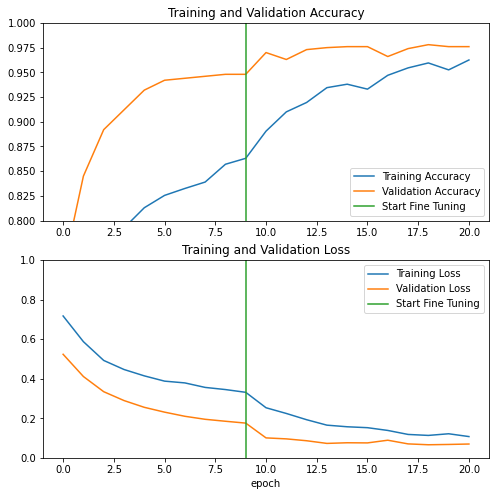

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()